In [11]:
## Importing necessary libraries

import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import multivariate_normal as normal
import scipy.integrate as spi

In [12]:
'''
The acc_generator function generates a randomized trajectory for the
lead vehicle with acceleration changes after every num_constants seconds
and also following the Markovian property
'''
def acc_generator(acc_init, num_changes, mu, sigma, num_constants=10, markovian_acc = True):
    
    sigma_acc = sigma   
    mu_acc = mu
    acc = acc_init
    rvs = np.array(acc_init)    
    
    p_u = normal(mu_acc, sigma_acc*np.eye(1))    
    new_array_ = acc*np.ones([1, num_constants])
    acc_gen = new_array_
        
    for i in range(num_changes-1):
        if markovian_acc:
            p_u_t = normal(acc, sigma_acc*np.eye(1))
        else:
            p_u_t = p_u

        acc = p_u_t.rvs(1)
        rvs = np.append(rvs, acc)
        
        new_array_ = acc*np.ones([1, num_constants])
        acc_gen = np.append(acc_gen, new_array_)
        
    return acc_gen, rvs

In [8]:
# IDM model parameters (standard units)

s0 = 2 # minimum distance between vehicles
v0 = 50 # speed of vehicle in free traffic
a = 0.73 # maximum acceleration
b = 1.67 # comfortable deceleration
T = 1.5 # safe time headway - min time to front vehicle
delta = 4 # exponent of acceleration
carlen = 4 # length of the vehicles (L)

# Additional parameters
gamma = 1 #rarity param for hi-dim
a_max = 2 # maximum acceleration of AV
d_max = gamma # maximum deceleration of AV
acc_change_freq = 15 # frequency at which the acceleration of lead vehicle changes randomly
conf_dist = 5 # conflict distance

# Initial States : v = {x_follow, x_lead, v_follow}
x_follow = 0 # initial position of follower vehicle
x_lead = 50 # initial position of lead vehicle
v_follow = 20 # initial speed of follower vehicle #use 20
v_lead_init = 20 # initial speed of lead vehicle #use 20
acc_init = 0.5 # initial acceleration of lead vehicle #use 0.5
sigma_acc = 0.3 #use 0.3
markovian_acc = True #use True

# Simulation Time
t_init = 0 # initial time
t_final = 60 # final time

# Initialize simulation runs
v_init = np.array([x_follow, x_lead, v_follow]) # Initial state of simulation
t = np.linspace(t_init, t_final, t_final-t_init+1) # time vector for ode simulation

'''
The f() function is the ordinary differential equation being solved for the 
Intelligent Driver Model (IDM). s_star() is a supporting function for f()
'''
def f(v, t0, v_l_traj):
    idx = np.round(t0).astype('int')
    T = len(v_l_traj)-1
    #print("===", idx)
    if idx > T:
        idx=T
        
    v_l = v_l_traj[idx]
    x_f_dot = v[2]
    x_l_dot = v_l
    v_f_dot = a*(1 - (v[2]/v0)**delta - (s_star(v[2],(v[2] - v_l))/(v[1] - v[0] - carlen))**2)
    
    if v_f_dot > a_max:
        v_f_dot = a_max
    elif v_f_dot < -d_max:
        v_f_dot = -d_max
        
    return np.r_[x_f_dot,x_l_dot,v_f_dot]

def s_star(v_f, v_f_del):
    return s0 + v_f*T + v_f*v_f_del/(2*np.sqrt(a*b))

'''
The fsys() function takes the accelertion profile of the lead vehicle (LV)
and simulates the behaviour of the AV by running the IDM 
'''

def fsys(acc_profile):
    acc = acc_profile
    
    v_l_traj = [v_lead_init]

    for i in range(1, acc.shape[0]+1):
        v_new = max(0,v_l_traj[i-1] + acc[i-1])
        v_l_traj.append(v_new)

    # Simulate the ODE describing the IDM model
    v = spi.odeint(f, v_init, t, args=(v_l_traj,))

    # Determine crash or not
    crash = 0

    for j in range(len(v)):
        if (v[j,1]  - v[j,0] < conf_dist) * (crash == 0):
            crash = 1
            
    return crash, v_l_traj, v

In [9]:
'''
The plotter() function plots the states of the simulation and also
specifies if crash has occured or not
'''
def plotter(acc_traj):
    # Determine crash or not
    crash = 0
    t_star= t.shape[0]

    for j in range(len(v)):
        if (v[j,1]  - v[j,0] < conf_dist) * (crash == 0):
            crash = 1
            t_star = j

    if crash == 0:
        print('Crash does not occur!')
    else:
        print('Crash occurs at {}!'.format(t_star))
        
        
    plt.rcParams["font.size"] = 30

    plt.plot(v[0:t_star+1,1], label='LV')
    plt.plot(v[0:t_star+1,0], label='AV')
    plt.ylabel('$X_t$ (m)')
    plt.xlabel('$t$ (sec)')
    #plt.title('Position of the lead vehicle (LV) and autonomous vehicle (AV)', fontweight="bold")
    plt.title('Position', fontweight="bold")
    plt.legend(fontsize=18)
    plt.show()


    plt.plot(v[0:t_star+1,1] - v[0:t_star+1,0], label="Distance")
    plt.axhline(y=conf_dist, c='C3', label="Crash Thres.")
    plt.ylabel('$D_t$ (m)')
    plt.xlabel('$t$ (sec)')
    plt.title('Distance', fontweight="bold")
    plt.legend(fontsize=18)
    plt.show()


    plt.plot(v_l_traj[0:t_star+1], label='LV')
    plt.plot(v[0:t_star+1,2], label='AV')
    plt.ylabel('$V_t$ (m/sec)')
    plt.xlabel('$t$ (sec)')
    plt.title('Speed', fontweight="bold")
    plt.legend(fontsize=18)
    plt.show()


    plt.plot(10+acc_traj[0:t_star+1], label='LV')
    plt.plot(10+np.diff(v[0:t_star+1,2]), label='AV')
    plt.ylabel('$u_t$')
    plt.xlabel('$t$ (sec)')
    plt.title('Action', fontweight="bold")
    plt.legend(fontsize=18)
    plt.show() 

Crash does not occur!


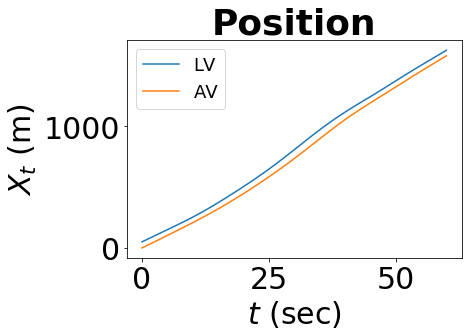

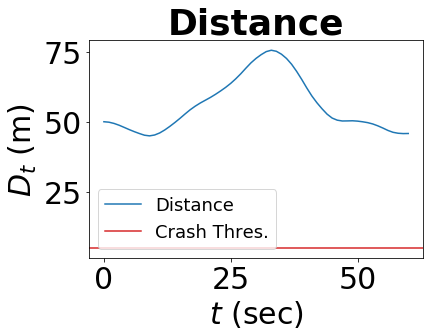

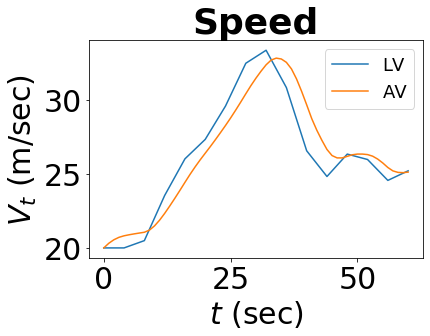

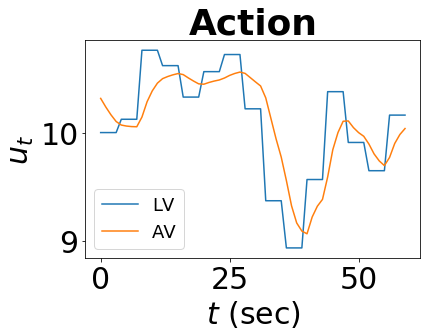

In [10]:
## Run an episode of the IDM car following simulation

acc, as_ = acc_generator(acc_init=0, num_changes=acc_change_freq, mu=0, sigma=sigma_acc, num_constants=4, markovian_acc = True)

crash, v_l_traj, v = fsys(acc)

plotter(acc)
